In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.cuda.empty_cache()
class double_conv2d_bn(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, strides=1, padding=1):
        super(double_conv2d_bn, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=strides, padding=padding, bias=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=strides, padding=padding, bias=True)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out

class deconv2d_bn(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, strides=2):
        super(deconv2d_bn, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=strides, bias=True)
        # Example of adding padding to a convolutional layer

        self.bn1 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        return out

class Unet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(Unet, self).__init__()
        self.layer1_conv = double_conv2d_bn(input_channels, 8)
        self.layer2_conv = double_conv2d_bn(8, 16)
        self.layer3_conv = double_conv2d_bn(16, 32)
        self.layer4_conv = double_conv2d_bn(32, 64)
        self.layer5_conv = double_conv2d_bn(64, 128)
        self.layer6_conv = double_conv2d_bn(128, 64)
        self.layer7_conv = double_conv2d_bn(64, 32)
        self.layer8_conv = double_conv2d_bn(32, 16)
        self.layer9_conv = double_conv2d_bn(16, 8)
        self.layer10_conv = nn.Conv2d(8, output_channels, kernel_size=3, stride=1, padding=1, bias=True)

        self.deconv1 = deconv2d_bn(128, 64)
        self.deconv2 = deconv2d_bn(64, 32)
        self.deconv3 = deconv2d_bn(32, 16)
        self.deconv4 = deconv2d_bn(16, 8)

        self.sigmoid = nn.Sigmoid()
        self.input_channels = input_channels  # Update input channels
        self.output_channels = output_channels

    def forward(self, x):
        conv1 = self.layer1_conv(x)

        pool1 = F.max_pool2d(conv1, 2)

        conv2 = self.layer2_conv(pool1)
        pool2 = F.max_pool2d(conv2, 2)

        conv3 = self.layer3_conv(pool2)
        pool3 = F.max_pool2d(conv3, 2)

        conv4 = self.layer4_conv(pool3)
       

        pool4 = F.max_pool2d(conv4, 2)

        conv5 = self.layer5_conv(pool4)

        convt1 = self.deconv1(conv5)
        convt1 = F.interpolate(convt1, size=(4, 4), mode='bilinear', align_corners=False)
        concat1 = torch.cat([convt1, conv4], dim=1)
        conv6 = self.layer6_conv(concat1)

        convt2 = self.deconv2(conv6)
        convt2 = F.interpolate(convt2, size=(8, 8), mode='bilinear', align_corners=False)
        concat2 = torch.cat([convt2, conv3], dim=1)

        conv7 = self.layer7_conv(concat2)

        convt3 = self.deconv3(conv7)
        concat3 = torch.cat([convt3, conv2], dim=1)
        conv8 = self.layer8_conv(concat3)

        convt4 = self.deconv4(conv8)
        concat4 = torch.cat([convt4, conv1], dim=1)
        conv9 = self.layer9_conv(concat4)
        outp = self.layer10_conv(conv9)
        outp = self.sigmoid(outp)

        return outp


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(100, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 1024)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x



class CombinedModel(nn.Module):
    def __init__(self):
        super(CombinedModel, self).__init__()
        self.neural_network = NeuralNetwork()
        self.unet = Unet(input_channels=3, output_channels=3)

    def forward(self, x):
        # Split the input tensor along the second dimension (assuming x has shape [batch_size, 3, 100])
        split_tensors = torch.split(x, 1, dim=2)
        # Process each split tensor through the neural network and concatenate the results
        nn_outputs_1 = self.neural_network(split_tensors[0].squeeze(2))
        nn_outputs_2 = self.neural_network(split_tensors[1].squeeze(2))
        nn_outputs_3 = self.neural_network(split_tensors[2].squeeze(2))

        # Concatenate the results along the second dimension
        nn_output = torch.cat([nn_outputs_1.unsqueeze(2), nn_outputs_2.unsqueeze(2), nn_outputs_3.unsqueeze(2)], dim=2)


        # Ensure nn_output has three channels
        

        # Reshape nn_output to match the expected input shape of the U-Net
        nn_output = nn_output.view(nn_output.size(0), 3, 32, 32)
     
     
        # Pass the processed tensor through the U-Net
        unet_output = self.unet(nn_output)

        # Flatten the U-Net output
        unet_output = unet_output.view(unet_output.size(0), 3, -1)
        unet_output= unet_output.permute(0, 2, 1)




        return unet_output


# 创建合并后的模型
# Create an instance of CombinedModel
combined_model = CombinedModel()

# Move the model to the specified device
model = combined_model.to(device)

print(f"Before forward pass - GPU memory used: {torch.cuda.memory_allocated() / 1e9} GB")

Before forward pass - GPU memory used: 0.00536832 GB


In [2]:
import pickle
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 读取.pkl文件
with open('cifar10unbalance-train-spikecount.pkl', 'rb') as file:
    input_data = pickle.load(file)

# 转换为张量
inputs = torch.tensor(input_data, dtype=torch.float32).to(device)
print(f"Before forward pass - GPU memory used: {torch.cuda.memory_allocated() / 1e9} GB")

with open('cifar10-train-raw_image.pkl', 'rb') as file:
    goal = pickle.load(file)

with open('cifar10unbalance-test-spikecount.pkl', 'rb') as file:
    test_data = pickle.load(file)
with open('cifar10-test-raw_image.pkl', 'rb') as file:
    test_goal = pickle.load(file)
test_data = torch.tensor(test_data, dtype=torch.float32).to(device)

goal = torch.tensor(goal, dtype=torch.float32).to(device)
test_goal = torch.tensor(test_goal, dtype=torch.float32).to(device)
goal=goal
test_goal=test_goal


print(inputs.shape)
print(goal.shape)
print(test_data.shape)
print(test_goal.shape)


Before forward pass - GPU memory used: 0.008968704 GB
torch.Size([3000, 100, 3])
torch.Size([3000, 1024, 3])
torch.Size([300, 100, 3])
torch.Size([300, 1024, 3])


In [3]:
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import tempfile
import numpy as np
print(f"Before forward pass - GPU memory used: {torch.cuda.memory_allocated() / 1e9} GB")

Before forward pass - GPU memory used: 0.050764288 GB


In [4]:
torch.cuda.empty_cache()
print(f"Before forward pass - GPU memory used: {torch.cuda.memory_allocated() / 1e9} GB")

Before forward pass - GPU memory used: 0.050764288 GB


In [5]:
from torch.utils.data import DataLoader, TensorDataset
import gc
torch.cuda.empty_cache()
print(f"Before forward pass - GPU memory used: {torch.cuda.memory_allocated() / 1e9} GB")

loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.8)


dataset = TensorDataset(inputs, goal)


# 定义DataLoader
dataloader = DataLoader(
    dataset=dataset, 
    batch_size=32,
    shuffle=True,
)  # 这样将保持图像和标签的对应关系
    
gc.collect()
torch.cuda.empty_cache()
print(f"Before forward pass - GPU memory used: {torch.cuda.memory_allocated() / 1e9} GB")

for epoch in range(500):
    for i, batch in enumerate(dataloader):
        inputs, goal = batch
        model_outputs = model(inputs)
        loss = loss_fn(model_outputs, goal)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()
    torch.cuda.empty_cache()
    gc.collect()
    print('Epoch: {}, Loss: {}'.format(epoch, loss.item()))
model.eval()

Before forward pass - GPU memory used: 0.050764288 GB
Before forward pass - GPU memory used: 0.050764288 GB
Epoch: 0, Loss: 0.0664835050702095
Epoch: 1, Loss: 0.06872056424617767
Epoch: 2, Loss: 0.07056785374879837
Epoch: 3, Loss: 0.06459257751703262
Epoch: 4, Loss: 0.06166620925068855
Epoch: 5, Loss: 0.06883639842271805
Epoch: 6, Loss: 0.06433383375406265
Epoch: 7, Loss: 0.06640175729990005
Epoch: 8, Loss: 0.06282450258731842
Epoch: 9, Loss: 0.058130621910095215
Epoch: 10, Loss: 0.06899378448724747
Epoch: 11, Loss: 0.04874364659190178
Epoch: 12, Loss: 0.0647057592868805
Epoch: 13, Loss: 0.06564651429653168
Epoch: 14, Loss: 0.06178029254078865
Epoch: 15, Loss: 0.06398843973875046
Epoch: 16, Loss: 0.05542435497045517
Epoch: 17, Loss: 0.04693165048956871
Epoch: 18, Loss: 0.050855763256549835
Epoch: 19, Loss: 0.0431206114590168
Epoch: 20, Loss: 0.04326252266764641
Epoch: 21, Loss: 0.048866041004657745
Epoch: 22, Loss: 0.04584641009569168
Epoch: 23, Loss: 0.04130413010716438
Epoch: 24, Los

CombinedModel(
  (neural_network): NeuralNetwork(
    (fc1): Linear(in_features=100, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=1024, bias=True)
  )
  (unet): Unet(
    (layer1_conv): double_conv2d_bn(
      (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (layer2_conv): double_conv2d_bn(
      (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [6]:
testdataset = TensorDataset(test_data, test_goal)
testdataloader = DataLoader(
    dataset=testdataset, 
    batch_size=32,
    shuffle=True,
) 
criterion = torch.nn.MSELoss()

test_loss = 0.0
total_batches = 0
with torch.no_grad():  # Disable gradient computation during testing
    for i, batch in enumerate(testdataloader):
        test_data, test_goal = batch
        model_outputs = model(test_data)
        loss = criterion(model_outputs, test_goal)
        test_loss += loss.item()
        total_batches += 1
average_test_loss = test_loss / total_batches
print('Average Test Loss: {}'.format(average_test_loss))

Average Test Loss: 0.036296820268034935


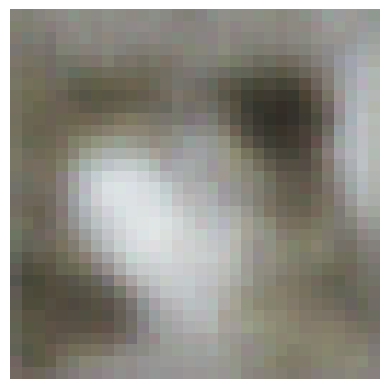

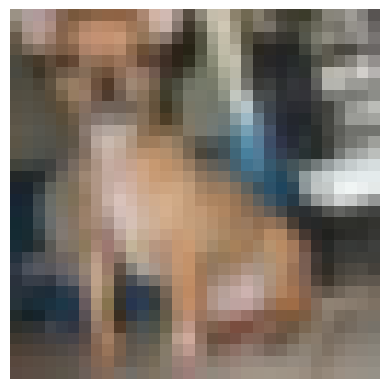

PSNR: 15.158041954040527


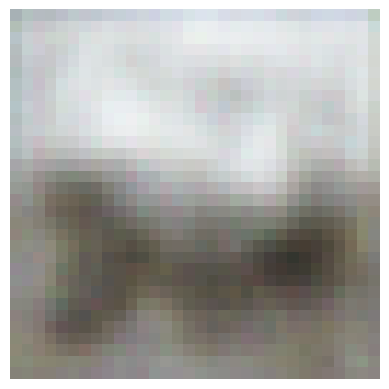

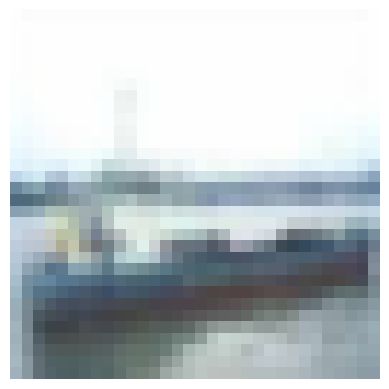

PSNR: 14.464582443237305


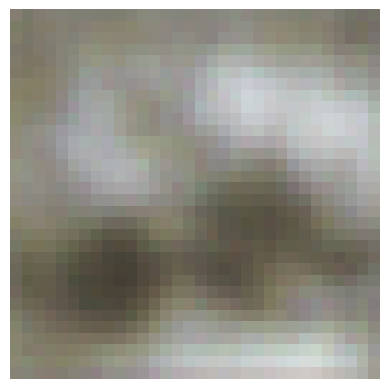

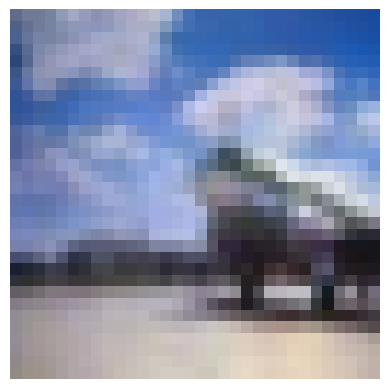

PSNR: 14.658998489379883


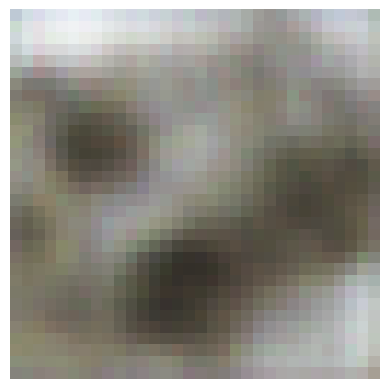

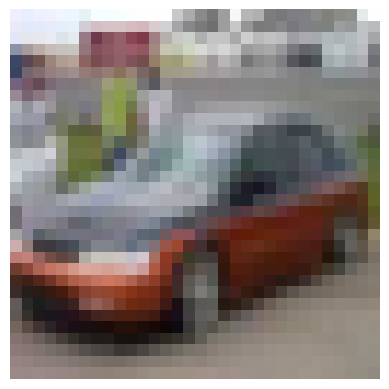

PSNR: 16.2337703704834


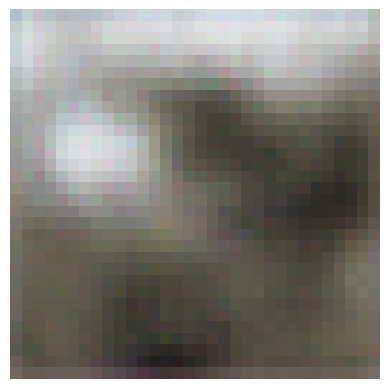

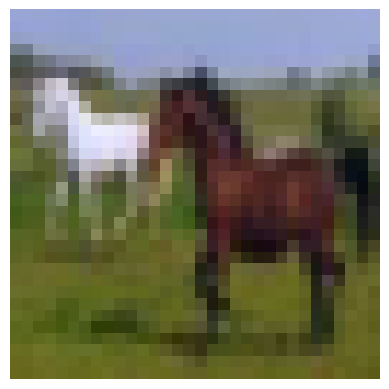

PSNR: 16.11710548400879


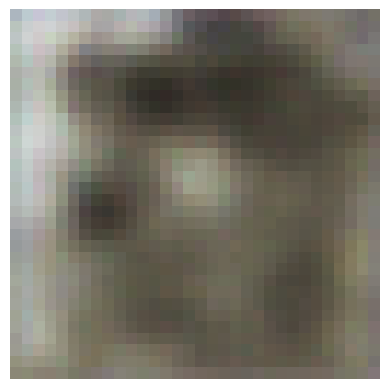

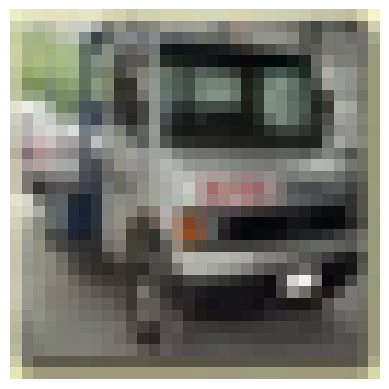

PSNR: 15.342374801635742


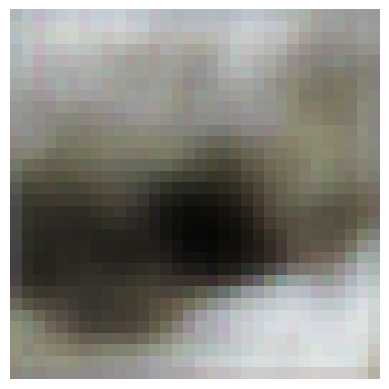

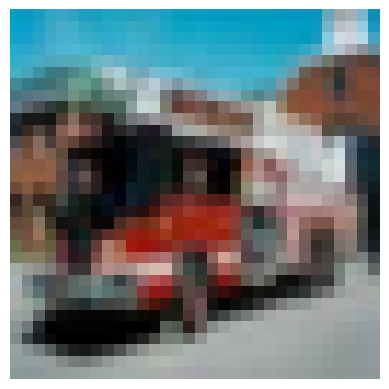

PSNR: 11.931907653808594


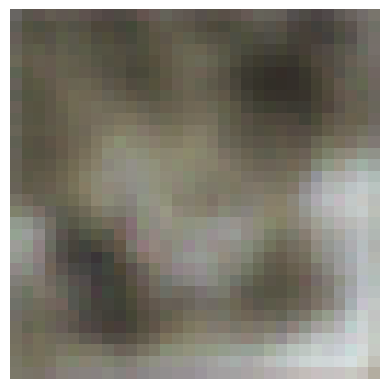

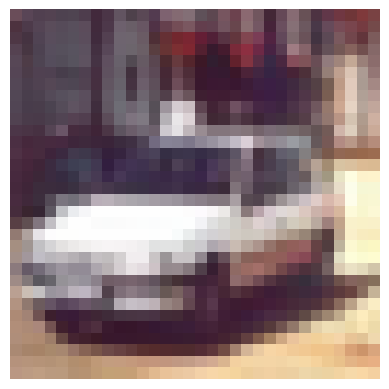

PSNR: 13.180246353149414


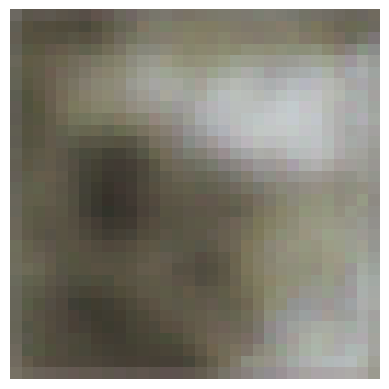

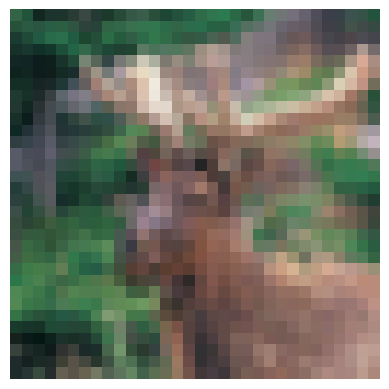

PSNR: 16.3316650390625


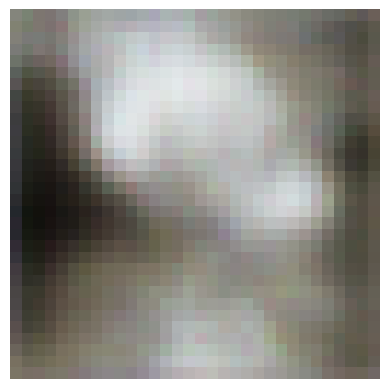

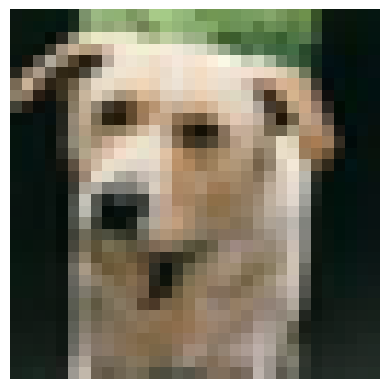

PSNR: 12.759684562683105


In [8]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

with torch.no_grad():
    reconstructed_images = model_outputs[:10]
    for i, image in enumerate(reconstructed_images):
        # 使用 reshape 替代 view
        image = image.reshape(32, 32,3).cpu()
  

        # 下面的代码显示原始图像，确保你有对应的原始图像数据
        original_image = test_goal[i].view(32, 32,3).cpu()


        original_image_np = original_image.detach().cpu().numpy().squeeze()
        image_np = image.detach().cpu().numpy().squeeze()

        original_image_np = original_image_np.astype(float)
        image_np = image_np.astype(float)

        mse = F.mse_loss(image, original_image)
        psnr = 20 * torch.log10(1 / torch.sqrt(mse))

        plt.imshow(image)  # Assuming the last dimension is channel
        plt.axis('off')
        plt.show()

        plt.imshow(original_image)  # Assuming the last dimension is channel
        plt.axis('off')
        plt.show()

        print(f"PSNR: {psnr}")

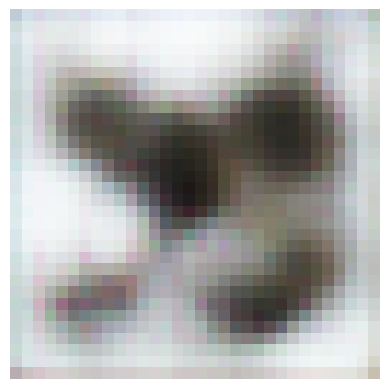

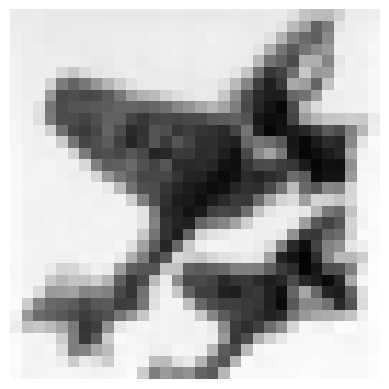

PSNR: 15.636320114135742


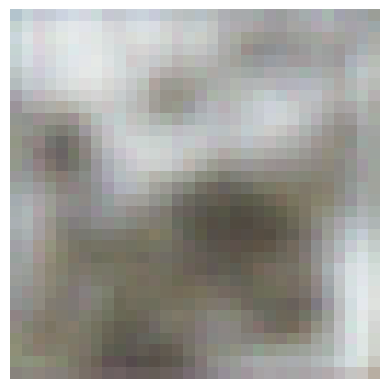

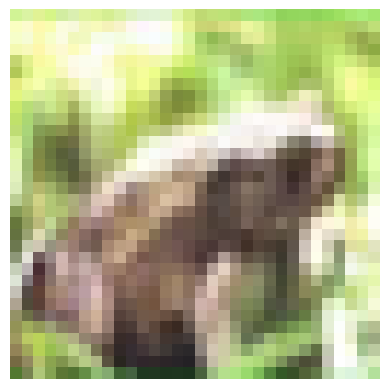

PSNR: 15.496350288391113


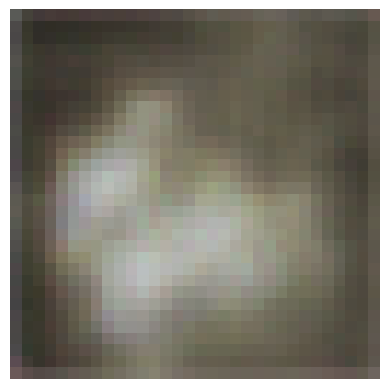

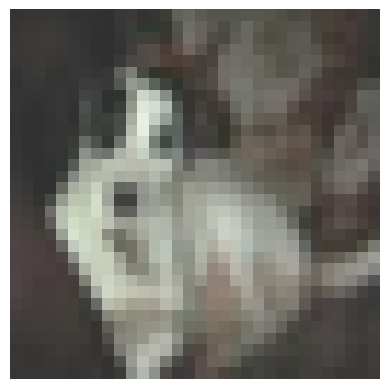

PSNR: 19.809541702270508


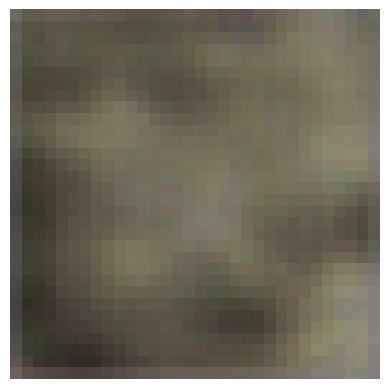

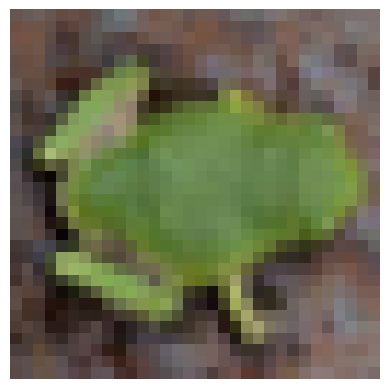

PSNR: 20.355913162231445


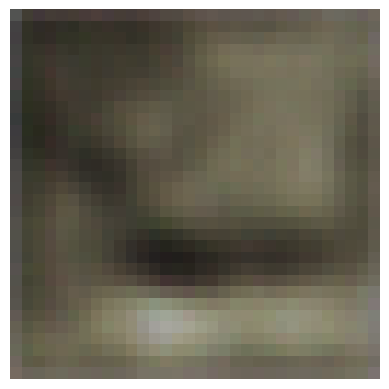

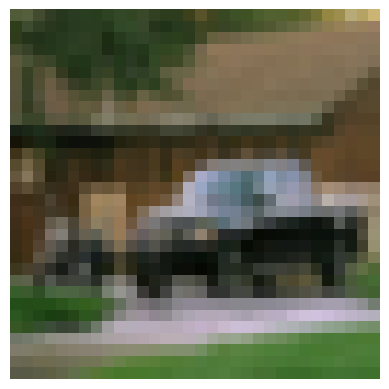

PSNR: 17.846942901611328


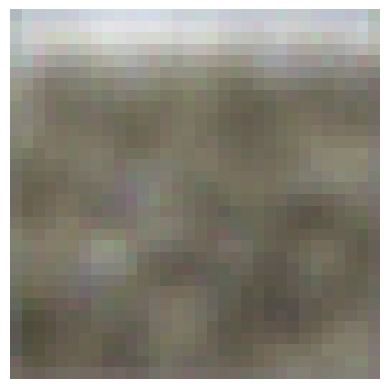

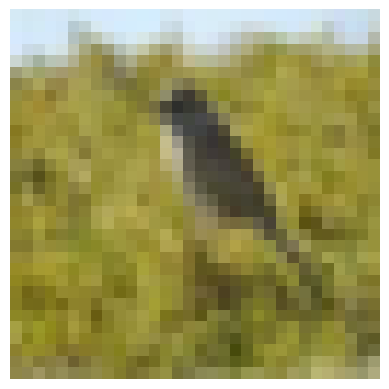

PSNR: 17.108125686645508


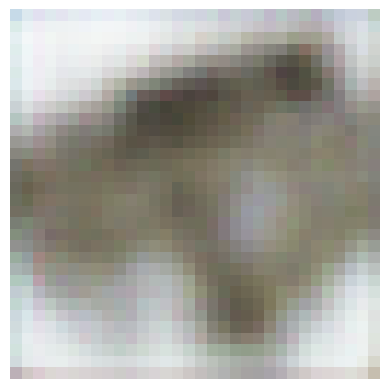

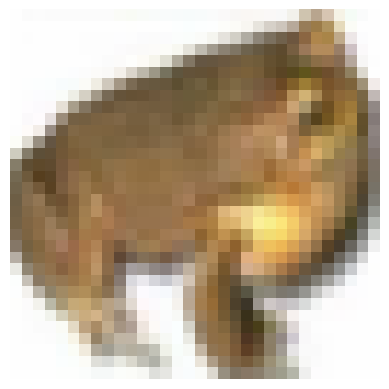

PSNR: 16.68983268737793


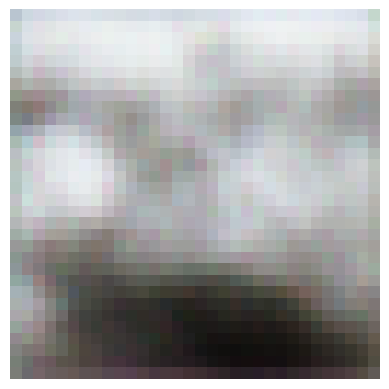

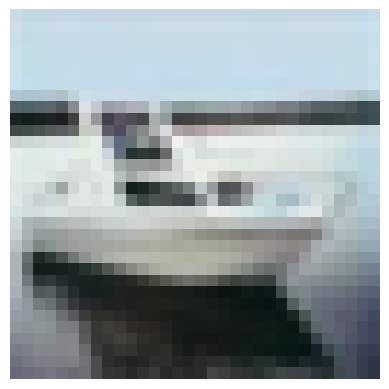

PSNR: 16.906024932861328


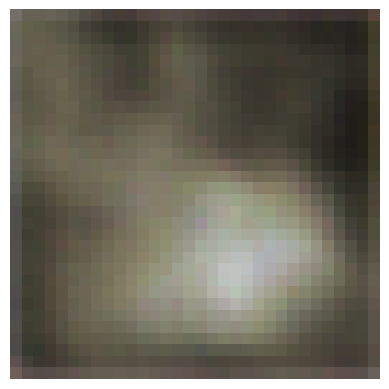

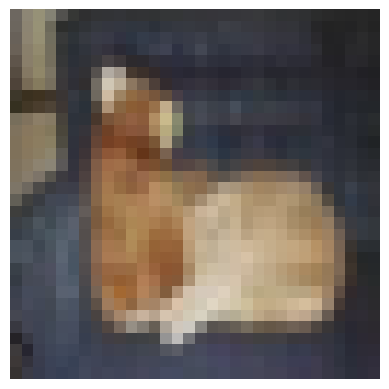

PSNR: 19.403823852539062


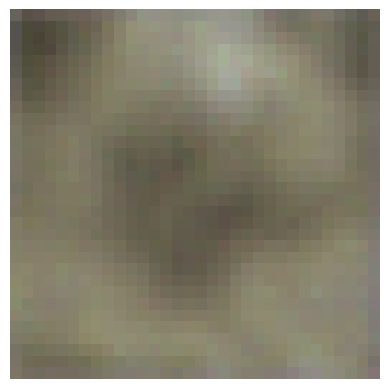

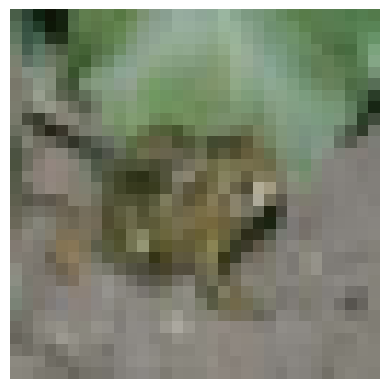

PSNR: 21.56488609313965


In [9]:
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim

with torch.no_grad():
    reconstructed_images = model(inputs[:10])
    for i, image in enumerate(reconstructed_images):

        # 使用 reshape 替代 view
        image = image.reshape(32, 32,3).cpu()
  

        # 下面的代码显示原始图像，确保你有对应的原始图像数据
        original_image = goal[i].view(32, 32,3).cpu()


        original_image_np = original_image.detach().cpu().numpy().squeeze()
        image_np = image.detach().cpu().numpy().squeeze()

        original_image_np = original_image_np.astype(float)
        image_np = image_np.astype(float)

        mse = F.mse_loss(image, original_image)
        psnr = 20 * torch.log10(1 / torch.sqrt(mse))

        plt.imshow(image)  # Assuming the last dimension is channel
        plt.axis('off')
        plt.show()

        plt.imshow(original_image)  # Assuming the last dimension is channel
        plt.axis('off')
        plt.show()

        print(f"PSNR: {psnr}")

In [10]:
import pickle
import os

# Assuming 'model' is an instance of your PyTorch model
# ...

# Specify the path to the desktop and the filename
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
file_path = os.path.join(desktop_path, 'unet_model_cifar10_unbalance.pth')

# Save the model state dictionary
model_state_dict = model.state_dict()
torch.save(model_state_dict, file_path)